<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/03_TextImage/examples/text_processing_sparse_matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text processing - Training with Sparse Matrices

This notebook demonstrates how to extract text features and combine other features into a sparse matrix dataset for training.

Dataset: https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

### Description (from Kaggle)

This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:
```
Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
Age: Positive Integer variable of the reviewers age.
Title: String variable for the title of the review.
Review Text: String variable for the review body.
Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
Division Name: Categorical name of the product high level division.
Department Name: Categorical name of the product department name.
Class Name: Categorical name of the product class name.
```

In [1]:
# To fix this issue: https://github.com/mwaskom/seaborn/issues/1773
!pip install matplotlib==3.2.0rc1

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline
sns.set(style='whitegrid')

In [3]:
# Setup nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk import SnowballStemmer, word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# 1. Load the dataset in pandas
# index_col will use column 0 as the index instead of generating one based on row number
df = pd.read_csv(
    'https://raw.githubusercontent.com/AFAgarap/ecommerce-reviews-analysis/master/Womens%20Clothing%20E-Commerce%20Reviews.csv', index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
# 2. Use CountVectorizer to convert Title (drop the NaN values)

# drop NaN first
#
# Alternatively, you can impute empty string '' for rows with no title or no text
# (try this if you inspected the NaN rows and decide to include them)
#
df.dropna(subset=['Title', 'Review Text', 'Department Name'], inplace=True)
# df.dropna(inplace=True) # drop everything (alternative)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19662 entries, 2 to 23485
Data columns (total 10 columns):
Clothing ID                19662 non-null int64
Age                        19662 non-null int64
Title                      19662 non-null object
Review Text                19662 non-null object
Rating                     19662 non-null int64
Recommended IND            19662 non-null int64
Positive Feedback Count    19662 non-null int64
Division Name              19662 non-null object
Department Name            19662 non-null object
Class Name                 19662 non-null object
dtypes: int64(5), object(5)
memory usage: 1.7+ MB


### Tokenise, Remove Stopwords, and Stem

For CountVectorizer and TfidfVectorizer, customise the tokenisation step so that we can perform the above text data cleaning operations.

In [6]:
# Fancy version: use a callable class
class StemmerTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer(language='english')
        self.stop = set(stopwords.words('english'))

    def __call__(self, doc):

        # tokenize text into tokens
        tokens = word_tokenize(doc)

        # strip out punctuation
        words = [t for t in tokens if t.isalpha()]
        
        # strip out stopwords
        words = [t for t in words if t not in self.stop]
        
        # stem each token
        return [self.stemmer.stem(t) for t in words]

# test with something
StemmerTokenizer()('I think I have a stop word somewhere, hello??')

['i', 'think', 'i', 'stop', 'word', 'somewher', 'hello']

In [7]:
# Simpler version: use a function
def my_tokeniser(document):
    stops = set(stopwords.words('english'))
    stemmer = SnowballStemmer(language='english')

    tokens = word_tokenize(document)
    #       stem           every token  
    return [stemmer.stem(t) for t in tokens
            if t.isalpha() # if it is alphanumeric
               and t.lower() not in stops] # and not a stop word
               # (stopword list compares lowercase tokens)

# test with something
my_tokeniser('I think I have a stop word somewhere, hello??')

['think', 'stop', 'word', 'somewher', 'hello']

In [81]:
# if using the callable class-based tokeniser
# count_vec = CountVectorizer(ngram_range=(1, 2),
#                           tokenizer=StemmerTokenizer())

# if using the function tokeniser                         
count_vec = CountVectorizer(tokenizer=my_tokeniser)

count_title = count_vec.fit_transform(df['Title'])
count_title

<19662x2855 sparse matrix of type '<class 'numpy.int64'>'
	with 46010 stored elements in Compressed Sparse Row format>

In [82]:
print(count_title) # output is in CSR format

  (0, 1485)	1
  (0, 682)	1
  (0, 939)	1
  (1, 896)	1
  (1, 352)	1
  (2, 936)	1
  (2, 2149)	1
  (3, 1783)	1
  (4, 364)	1
  (4, 2144)	1
  (4, 1008)	1
  (5, 2144)	1
  (5, 2415)	1
  (5, 1063)	1
  (5, 1445)	1
  (6, 936)	1
  (7, 1008)	1
  (7, 741)	1
  (8, 741)	1
  (8, 1428)	1
  (8, 1402)	1
  (8, 1476)	1
  (8, 424)	1
  (8, 1504)	1
  (9, 1771)	1
  :	:
  (19652, 741)	1
  (19652, 619)	1
  (19653, 429)	1
  (19654, 810)	1
  (19655, 2629)	1
  (19656, 1008)	1
  (19656, 1794)	1
  (19657, 741)	1
  (19657, 1094)	1
  (19657, 1492)	1
  (19657, 1672)	1
  (19658, 1476)	1
  (19658, 2781)	1
  (19658, 568)	1
  (19659, 619)	1
  (19659, 2100)	1
  (19660, 741)	1
  (19660, 1771)	1
  (19660, 1744)	1
  (19660, 619)	1
  (19660, 2393)	1
  (19661, 1402)	1
  (19661, 1825)	1
  (19661, 1692)	1
  (19661, 1486)	1


In [83]:
# vocabulary is one way to check if tokeniser is working properly
# all words should be stemmed and cleaned
count_vec.get_feature_names()

['ab',
 'abroad',
 'abso',
 'absolut',
 'accent',
 'accessori',
 'accident',
 'accur',
 'ack',
 'ackerley',
 'across',
 'acryl',
 'activ',
 'actual',
 'ad',
 'add',
 'addit',
 'adjust',
 'adn',
 'ador',
 'adorb',
 'advertis',
 'aesthet',
 'afford',
 'afternoon',
 'ag',
 'age',
 'agre',
 'agreement',
 'ah',
 'ahahahaha',
 'ahead',
 'ahhhhmaz',
 'ahirt',
 'ahoy',
 'air',
 'airi',
 'aka',
 'akemi',
 'akward',
 'ala',
 'albert',
 'alicia',
 'align',
 'alittl',
 'aliv',
 'allelujah',
 'alless',
 'allison',
 'allow',
 'allroad',
 'allur',
 'almost',
 'alon',
 'along',
 'alpinia',
 'alreadi',
 'alright',
 'also',
 'alter',
 'altern',
 'alway',
 'amaz',
 'amazing',
 'amd',
 'amnesti',
 'among',
 'amoret',
 'amount',
 'amp',
 'ampl',
 'an',
 'anastasia',
 'andfest',
 'angel',
 'angl',
 'anim',
 'ankl',
 'annoy',
 'anorak',
 'anoth',
 'anrtho',
 'answer',
 'anther',
 'anthousai',
 'anticip',
 'antoh',
 'anyon',
 'anyth',
 'anytim',
 'anywher',
 'apart',
 'appar',
 'appeal',
 'appear',
 'appl',
 

In [84]:
# 3. Use TfidfVectorizer to convert Review Text

tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), tokenizer=my_tokeniser)

tfidf_review = tfidf_vec.fit_transform(df['Review Text'])
tfidf_review

<19662x210804 sparse matrix of type '<class 'numpy.float64'>'
	with 1039696 stored elements in Compressed Sparse Row format>

In [85]:
tfidf_vec.get_feature_names()

['aa',
 'aa littl',
 'aa size',
 'aaaaaaamaz',
 'aaaaaaamaz tunic',
 'aaaaannnnnnd',
 'aaaaannnnnnd actual',
 'aaaah',
 'aaaah galor',
 'aaaahmaz',
 'aaaahmaz seafolli',
 'aaah',
 'aaah beauti',
 'aam',
 'aam apttern',
 'ab',
 'ab fab',
 'ab said',
 'ab snap',
 'abbey',
 'abbey ladi',
 'abbey velvet',
 'abbi',
 'abbi parti',
 'abbi vintag',
 'abck',
 'abck think',
 'abdomen',
 'abdomen also',
 'abdomen everyth',
 'abdomen hip',
 'abdomen lay',
 'abdomen serious',
 'abdomin',
 'abdomin region',
 'abercrombi',
 'abercrombi jeg',
 'abhor',
 'abhor anyth',
 'abil',
 'abil dress',
 'abil flatter',
 'abil go',
 'abil reach',
 'abil repel',
 'abil retain',
 'abil wear',
 'abl',
 'abl actual',
 'abl add',
 'abl adjust',
 'abl bend',
 'abl breath',
 'abl bring',
 'abl button',
 'abl buy',
 'abl carri',
 'abl chang',
 'abl check',
 'abl clean',
 'abl close',
 'abl count',
 'abl cover',
 'abl dress',
 'abl easili',
 'abl enjoy',
 'abl exchang',
 'abl find',
 'abl fit',
 'abl fix',
 'abl flatter',

In [86]:
# 4. Combine into 1 sparse matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html
# Include these columns to your final sparse matrix
# - Age
# - Department Name

# first one hot encode Department Name, then make it a sparse matrix
encoded_department = pd.get_dummies(df[['Department Name']])
sparse_department = csr_matrix(encoded_department)

# create a sparse matrix of the other columns
sparse_others = csr_matrix(df.loc[:, ['Age']].values)

sparse_all = hstack([tfidf_review, count_title, sparse_department, sparse_others],
                    format='csr')
sparse_all

<19662x213666 sparse matrix of type '<class 'numpy.float64'>'
	with 1125030 stored elements in Compressed Sparse Row format>

### Feature Reduction

Since there are over 227k features, feature selection with kbest is unfeasible.

We will apply a version of PCA that suppports sparse matrices.

Before we do that, we will also scale the features so that the variance is normalised.

In [87]:
# PCA (sparse version) for feature reduction
# The classic PCA only works with dense matrices
pca = TruncatedSVD(n_components=100) # can tune later
scaler = StandardScaler(with_mean=False)
sparse_all_sc = scaler.fit_transform(sparse_all)
Z_100d = pca.fit_transform(sparse_all_sc)
Z_100d

array([[ 1.18292528e+01, -2.87930453e+00,  2.12048987e+00, ...,
         6.35140346e+00, -1.21211261e+00, -4.06812228e+00],
       [ 5.35898888e+00, -3.18010019e-01, -5.67745075e-02, ...,
         4.04011487e-02,  6.70498684e-01, -3.92626224e-01],
       [ 6.04371719e+00, -3.06162733e-02, -7.35377585e-02, ...,
        -1.32740035e-01,  3.25286369e-01, -2.51569404e-01],
       ...,
       [ 6.93155740e+00, -6.90835814e-02, -7.94300087e-02, ...,
        -2.07937178e-01, -1.00532800e-02,  3.38590368e-01],
       [ 9.20964567e+00, -1.31231909e-02,  4.59219216e-01, ...,
         5.30185226e-01, -1.43886351e+00,  3.64064772e-01],
       [ 5.28403554e+00, -7.81020430e-02, -4.25532883e-02, ...,
        -3.38673541e-02, -1.04600813e-01,  9.65288115e-03]])

### Imbalance check

As this is a classification problem, we check if the target column is balanced.

If not, perform undersampling. This is a demo of how to use the imblearn library.

In [88]:
X = Z_100d
y = df['Recommended IND']
y.value_counts() # is this balanced?

1    16087
0     3575
Name: Recommended IND, dtype: int64

In [89]:
# random undersampling using imblearn
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html
sampler = RandomUnderSampler(random_state=22)

X_balanced, y_balanced = sampler.fit_resample(X, y)
np.unique(y_balanced, return_counts=True) # is this balanced?

(array([0, 1]), array([3575, 3575]))

In [90]:
# find out which indices are sampled, we will use this to find the
sampler.sample_indices_

array([   0,    3,    8, ..., 1924, 8292, 1004])

In [91]:
# add the index so that we can track back to the original row
# this will help in inspecting predictions to original text later
X_balanced_with_index = np.hstack([X_balanced, sampler.sample_indices_.reshape(-1, 1)])
X_balanced_with_index.shape

(7150, 101)

### Training

- Train-test split. We will split the balanced dataset with index, so that the index will be shuffled together with the training and test sets.

- Cross validation with Logistic Regression and SGD. We will use the training set without the index.

In [0]:
X_train_index, X_test_index, y_train, y_test = train_test_split(X_balanced_with_index,
                                                                y_balanced,
                                                                random_state=22,
                                                                stratify=y_balanced)
X_train = X_train_index[:, :-1] # exclude the last column (= the index)
X_test = X_test_index[:, :-1] # exclude the last column (= the index)

In [93]:
cv_results_log = cross_validate(SGDClassifier(loss='log', random_state=22), 
                                X_train, y_train, cv=3, return_estimator=True)
cv_results_log

{'estimator': (SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                random_state=22, shuffle=True, tol=0.001, validation_fraction=0.1,
                verbose=0, warm_start=False),
  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
                n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
                random_state=22, shuffle=True, tol=0.001, validation_fraction=0.1,
                verbose=0, warm_start=False),
  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0

In [94]:
cv_results_svc = cross_validate(SVC(gamma='auto'), 
                                X_train, y_train, cv=3, return_estimator=True)
cv_results_svc

{'estimator': (SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)),
 'fit_time': array([1.85052323, 1.84032536, 1.83843732]),
 'score_time': array([0.70921421, 0.71931314, 0.71341848]),
 'test_score': array([0.64988814, 0.67505593, 0.68197088])}

### Evaluation Metrics

In [95]:
model = cv_results_svc['estimator'][cv_results_svc['test_score'].argmax()]
pred = model.predict(X_test)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [96]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       894
           1       0.71      0.61      0.66       894

    accuracy                           0.68      1788
   macro avg       0.68      0.68      0.68      1788
weighted avg       0.68      0.68      0.68      1788



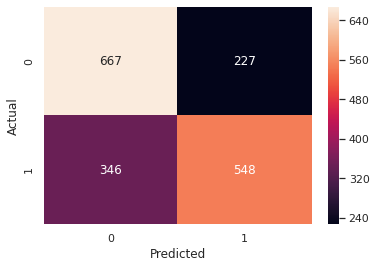

In [97]:
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred), fmt='d', annot=True,
            ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

### Observations

- Using a support vector classifier, we get an accuracy of 71% before any GridSearch or tuning.
- The incorrect predictions will be inspected by tracing back to the indices that were incorrect.
- If we used the other columns such as Rating, we may get a better accuracy. However, the Rating column may not be available if our scenario is to predict review sentiment based on text.

In [98]:
# Inspecting some incorrect predictions

# 1. get the mask of incorrect predictions
mask = y_test != pred

# 2. map to the indices
indices = X_test_index[mask, -1]

# 3. find some of the entries
df_incorrect = df.iloc[indices]

# 4. display as a dataframe
s_indices = pd.Series(pred[mask], index=df_incorrect.index, name='Prediction')

incorrect = pd.concat([df_incorrect, s_indices], axis=1)
incorrect.sort_index(inplace=True)
incorrect

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Prediction
43,89,67,Some things you should know...,"First, this is thermal ,so naturally i didn't ...",4,1,1,Initmates,Intimate,Sleep,0
90,1078,51,Sweet flattering dress,"I love cute summer dresses and this one, espec...",4,1,0,General Petite,Dresses,Dresses,0
498,850,33,Boxy,Cropped and wide- would look cuter on someone ...,3,0,0,General Petite,Tops,Blouses,1
500,850,29,Nice but short,"I really like the style of this top, and it's ...",3,1,15,General Petite,Tops,Blouses,0
528,984,31,Easy jacket,Slouchy relaxed fit. well sewn together and ha...,3,1,0,General,Jackets,Jackets,0
...,...,...,...,...,...,...,...,...,...,...,...
23369,1080,62,Too much fabric,Love the colors and top part but it runs extre...,5,1,1,General,Dresses,Dresses,0
23371,1110,23,Beautiful!,This dress is amazing! i have to say when i pi...,5,1,0,General Petite,Dresses,Dresses,0
23391,884,45,Tight in all the wrong places...,"The model looks awesome in this cute top, but ...",2,0,3,General Petite,Tops,Knits,1
23428,926,67,Beautiful !!!,I must say that at first i had mixed feelings ...,5,1,0,General,Tops,Sweaters,0


In [102]:
# Exploring vocab

# find the ones that match "beautiful"
count_vec_vocab = pd.Series(count_vec.get_feature_names())

count_vec_vocab[count_vec_vocab.str.startswith('beaut')]

186           beauti
187        beautifil
188    beautifulllll
189        beautigul
190        beautivul
191          beautti
192           beautu
dtype: object

In [105]:
# find titles that match "beautiful"

term_mask = incorrect['Title'].str.lower().str.contains('beaut')
incorrect[term_mask]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Prediction
777,895,38,Most beautiful sweater that i own!,"This is a bit pricey, but it's the most beauti...",5,1,3,General,Tops,Fine gauge,0
1438,1081,39,Beautiful casual dress,Love! highly recommend...usually i wait for sa...,5,1,0,General Petite,Dresses,Dresses,0
1499,829,44,Subtle beauty,I stumbled upon this by accident and i thought...,5,1,4,General Petite,Tops,Blouses,0
1787,867,32,"Beautiful drape, very deep v",I bought this yesterday and love it. it drapes...,5,1,2,General,Tops,Knits,0
2074,1072,33,Beautiful dress - runs huge!,I fell in love with this dress online and went...,5,1,14,General Petite,Dresses,Dresses,0
2440,1085,31,"Beautiful, but a bit boxy",I really wanted to love this dress. the cut ou...,4,1,7,General Petite,Dresses,Dresses,0
2827,1093,34,Beautiful dress but too dark,I was very excited about receiving this dress....,3,0,1,General Petite,Dresses,Dresses,1
3139,909,30,"Beautiful sweater, but pills",I love the look of this sweater and was so hap...,3,0,0,General,Tops,Fine gauge,1
3354,836,27,"Beautiful design, very sheer",I ran to the store to try to this on after see...,3,0,17,General Petite,Tops,Blouses,1
3819,828,25,"Beautiful top, but not on me","This top is gorgeous: beautiful lace, substant...",3,1,0,General,Tops,Blouses,0


In [110]:
# find the ones that similar to "horror"
count_vec_vocab[count_vec_vocab.str.startswith('hor')]

1189    horrend
1190    horribl
1191    horrifi
1192     horror
1193       hors
dtype: object

In [111]:
term_mask = incorrect['Title'].str.lower().str.contains('hor')
incorrect[term_mask]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Prediction
500,850,29,Nice but short,"I really like the style of this top, and it's ...",3,1,15,General Petite,Tops,Blouses,0
5481,909,43,Beautiful but not for those who are short waisted,I saw the orange/tangerine colored version of ...,4,1,32,General,Tops,Fine gauge,0
6788,877,38,Shorter in front than expected,"I'm 5' 2"" and 110 lbs. i ordered this in xsp b...",4,1,4,General,Tops,Knits,0
8765,1077,35,Too short,I'm a fan of yumi kim dresses and consistently...,2,0,1,General Petite,Dresses,Dresses,1
11094,873,41,Beautiful but too short!,"I'm 5'7"" with a dd bust and this top in a medi...",4,1,2,General,Tops,Knits,0
11343,829,61,"I joined the "" holding horses"" fan club",I visited my local retailer store to purchase ...,5,1,4,General Petite,Tops,Blouses,0
11670,682,61,"Not skirted, but has nylon over shorts",I ordered my usual size small. i din't notice ...,4,1,3,Initmates,Intimate,Lounge,0
12462,1072,37,Cute idea horrible fit,This was exactly the item i was looking for. s...,1,0,0,General Petite,Dresses,Dresses,1
13905,996,26,Runs small and short- why no size 16?,The skirt has a great cute design and great co...,4,0,4,General,Bottoms,Skirts,1
15256,835,49,Very short!!,"I love this fabric, and the design details of ...",3,1,6,General Petite,Tops,Blouses,0


In [113]:
# get the correct test entries
indices = X_test_index[~mask, -1]
df_correct = df.iloc[indices]
s_indices = pd.Series(pred[~mask], index=df_correct.index, name='Prediction')
correct = pd.concat([df_correct, s_indices], axis=1)
correct.sort_index(inplace=True)
correct

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Prediction
33,949,36,Mehh,"I ordered this 3 months ago, and it finally ca...",2,0,0,General,Tops,Sweaters,0
55,862,61,Soft and cute as can be!,This is an adorable top that i find to be extr...,5,1,2,General,Tops,Knits,1
61,368,36,Itchy tags,"3 tags sewn in, 2 small (about 1'' long) and 1...",1,0,0,Initmates,Intimate,Intimates,0
68,862,37,I wanted to love this top...,I really loved this top online and wanted to l...,2,0,0,General,Tops,Knits,0
88,845,38,Huge,"Really cute piece, but it's huge. i ordered an...",2,0,4,General Petite,Tops,Blouses,0
...,...,...,...,...,...,...,...,...,...,...,...
23389,834,47,"Color is off, middle too wide.","I so wanted to love this top. i ordered the ""b...",2,0,5,General Petite,Tops,Blouses,0
23434,862,58,Even cuter than picture shows,Lots of seam and stitching details make this e...,4,1,0,General Petite,Tops,Knits,1
23449,262,39,Not for me,I tried these on because the color is really p...,3,0,7,General Petite,Intimate,Lounge,0
23459,1094,57,Perfect except slip,This is my new favorite dress! my only complai...,4,1,3,General Petite,Dresses,Dresses,1


In [118]:
num_correct = correct['Title'].str.lower().str.contains('beaut').sum()
num_incorrect = incorrect['Title'].str.lower().str.contains('beaut').sum()

# what is the percentage accuracy?
num_correct / (num_incorrect + num_correct)

0.5607476635514018

In [119]:
num_correct = correct['Title'].str.lower().str.contains('hor').sum()
num_incorrect = incorrect['Title'].str.lower().str.contains('hor').sum()

# what is the percentage accuracy?
num_correct / (num_incorrect + num_correct) 

0.6666666666666666

In [125]:
indices = incorrect[incorrect['Title'].str.lower().str.contains('beaut')].index

(19662, 2855)

In [126]:
indices.values

array([  777,  1438,  1499,  1787,  2074,  2440,  2827,  3139,  3354,
        3819,  5117,  5481,  5696,  6729,  6999,  7285,  7832,  7862,
        8239, 10312, 11094, 11407, 11887, 11955, 12559, 12924, 12997,
       13342, 13474, 14229, 14889, 16705, 17257, 17369, 17427, 18595,
       19079, 19202, 19211, 19480, 19501, 20588, 21393, 22135, 22380,
       23371, 23428])